<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/main/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.12 and CUDA 11.3 for this tutorial. You may install other versions by change the version number in pip install command. 

## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

/home/robin/code/robin2/learning/mmsegmentation/demo


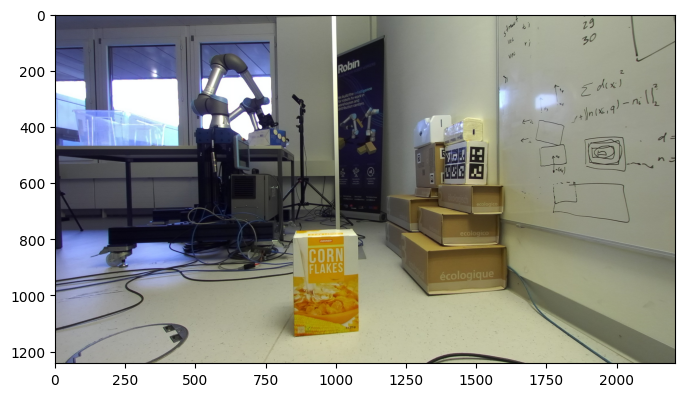

In [2]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt
import os 
#'../../data/robin/img_dir/37.png'
# shwo current path
print(os.getcwd())
# join with ../../data/robin/img_dir/37.png




img = mmcv.imread('../data/robin/img_dir/train/37.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))

plt.show()



We need to convert the annotation into semantic map format as an image.

In [3]:
from mmseg.datasets import RobinDataset

# define dataset root and directory for images and annotations
data_root = '../data/robin/'

data_prefix=dict(img_path='img_dir/train', seg_map_path='ann_dir/train')
dataset = RobinDataset(data_root=data_root, data_prefix=data_prefix, 
                        pipeline=[], 
                        img_suffix = '.png',
                        ann_suffix = '.png'
                        )
# define class and palette for better visualization
classes = ('background', 'box')
palette = [(0, 0, 255), (0, 255, 0)]

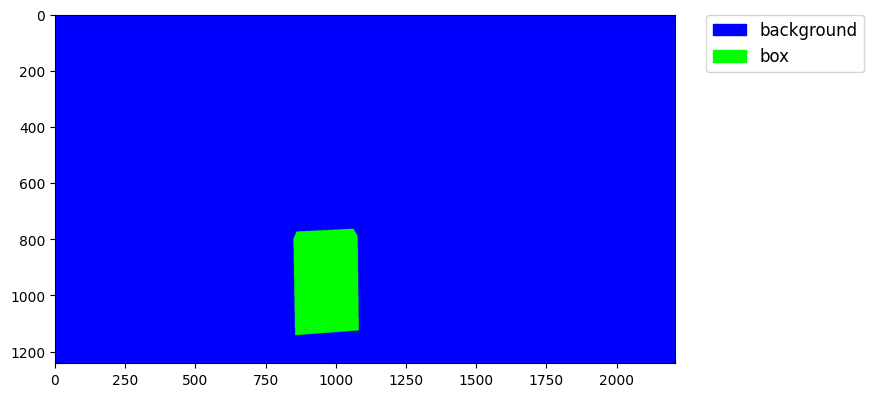

In [4]:
from PIL import Image
import numpy as np
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('../data/robin/ann_dir/train/37.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(len(classes))]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [5]:
import os.path as osp
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, data_prefix["seg_map_path"]), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
from mmengine import Config
#cfg = Config.fromfile('../configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
cfg = Config.fromfile('../configs/mask2former/mask2former_r50_8xb2-90k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),
    dist_cfg=dict(backend='nccl'))
vis_backends = [dict(type='LocalVisBackend')]
visualizer = dict(
    type='SegLocalVisualizer',
    vis_backends=[dict(type='LocalVisBackend')],
    name='visualizer')
log_processor = dict(by_epoch=False)
log_level = 'INFO'
load_from = None
resume = False
tta_model = dict(type='SegTTAModel')
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'
crop_size = (512, 1024)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(
        type='RandomChoiceResize',
        scales=[
            512, 614, 716, 819, 921, 1024, 1126, 1228, 1331, 1433, 1536, 1638,
            1740, 1843, 1945, 2048
        ],
        resize_type='ResizeShortestEdge',
        max_size=4096),
    dict(type='RandomCrop', crop_size=(512, 1024), cat_max_ratio=0.75),
    dict(type='RandomFlip', pro

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [11]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (512, 512)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
#cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.decode_head.out_channels = 1
cfg.model.decode_head.ignore_index = 0

#cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'RobinDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 1

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = data_prefix
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = data_prefix
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
#cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'
cfg.load_from = 'mask2former_r50_8xb2-90k_cityscapes-512x1024_20221202_140802-ffd9d750.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 1000
cfg.train_cfg.val_interval = 1000
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

### Train and Evaluation

In [23]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)


05/29 13:54:28 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3080 Ti
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=

/home/robin/miniconda3/lib/python3.10/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


05/29 13:54:29 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
05/29 13:54:29 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/robin/code/robin2/learning/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [24]:
# start training
runner.train()

05/29 13:54:33 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr=1e-05
05/29 13:54:33 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:weight_decay=0.05
05/29 13:54:33 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:lr_mult=0.1
05/29 13:54:33 - mmengine - INFO - paramwise_options -- backbone.conv1.weight:decay_mult=1.0
05/29 13:54:33 - mmengine - INFO - paramwise_options -- backbone.bn1.weight:lr=1e-05
05/29 13:54:33 - mmengine - INFO - paramwise_options -- backbone.bn1.weight:weight_decay=0.05
05/29 13:54:33 - mmengine - INFO - paramwise_options -- backbone.bn1.weight:lr_mult=0.1
05/29 13:54:33 - mmengine - INFO - paramwise_options -- backbone.bn1.weight:decay_mult=1.0
05/29 13:54:33 - mmengine - INFO - paramwise_options -- backbone.bn1.bias:lr=1e-05
05/29 13:54:33 - mmengine - INFO - paramwise_options -- backbone.bn1.bias:weight_decay=0.05
05/29 13:54:33 - mmengine - INFO - paramwise_options -- backbone.bn1.bias:lr_mult=0.1
05/29 13:54:33 

RuntimeError: weight tensor should be defined either for all 2 classes or no classes but got weight tensor of shape: [20]

In [17]:
# list files in ./work_dirs/tutorial
print(f"ls ./work_dirs/tutorial")
print(os.listdir('./work_dirs/tutorial'))

ls ./work_dirs/tutorial
['last_checkpoint', '20230521_182009', '20230521_205923', '20230521_204748', '20230521_204705', '20230521_211118', 'pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py', 'iter_200.pth']


Inference with trained model

Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_200.pth


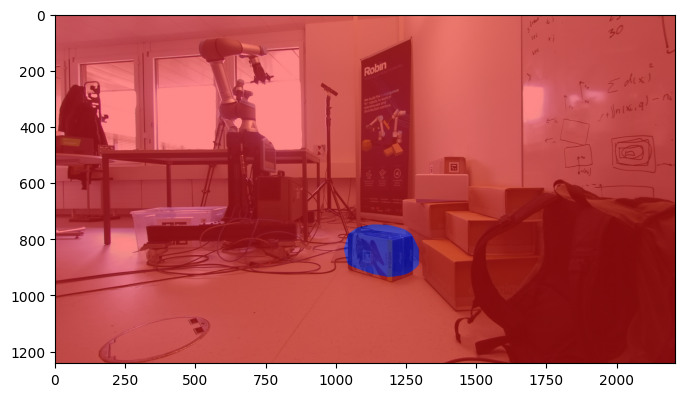

In [30]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/tutorial/iter_200.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

# read image again
img = mmcv.imread('../data/robin/img_dir/train/51.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))
